# Step 4 - Learning the customers and the conversion rate of the second item

*Do the same as Step 3 when instead the conversion rate associated with the second item is not known. Also assume that the number of customers per class is not known.*

In this scenario 

In [1]:
import mab.environment
import mab.Shop
from mab.ts_learner import *
from mab.ucb_learner import *
from mab.utilities import *

## Shop and Environment initialization

In this setting we have three shops:
1. **Clairvoyant**: which just naively tests all permutations of possible prices and picks the best one.
2. **TS**: which learns the best possible price using Thompson Sampling.
3. **UCB**: which learns the best possible price using Upper Confidence Bound.

The shops are assumed to know everything except for the price of the first item.

In [2]:
shop_ts = mab.Shop.Shop()
shop_ucb = mab.Shop.Shop()

shop_ts_normalized = mab.Shop.Shop()


shop_clairvoyant = mab.Shop.Shop()

env = mab.environment.Environment(shop_clairvoyant.prices1,shop_clairvoyant.prices2,shop_clairvoyant.discounts)

# The environment decides the conversion rates, which are shared among all the shops.
shop_clairvoyant.set_conv_rate(env.true_conv1, env.true_conv2)
shop_ts.set_conv_rate(env.true_conv1, None)
shop_ucb.set_conv_rate(env.true_conv1, None)

#Initialize learners
n_arms = len(env.prices1)
shop_ts.set_price_learner('TS', n_arms)
shop_ucb.set_price_learner('UCB', n_arms)

In [3]:
# we have fixed promo fractions
promo_fractions = np.array([[0.3, 0.2, 0.25, 0.25],     # every row is a customer class
                            [0.2, 0.25, 0.30, 0.25],     # every column is a promo type   
                            [0.1, 0.2, 0.3, 0.4],
                            [0.15, 0.15, 0.45, 0.25]])
                            
# we have a fixed price for item 2
price2_index = 2
price2 = env.prices2[price2_index]
max_ind_reward = price2 + max(env.prices1)

## Clairvoyant offline simulation
The Clairvoyant is run offline assuming that it knows every variable.

TBD

In [4]:
#### get clairvoyant price
expected_rewards = np.array([0.0, 0.0, 0.0, 0.0, 0.0])
customers_mean = np.array([25, 25, 25, 25])

for i in range(len(env.prices1)):
    for j in range(env.n_classes):
        expected_reward_from_class = customers_mean[j]*env.prices1[i]*env.true_conv1[j, i]
        for k in range(len(env.discounts)):
            expected_reward_from_class += promo_fractions[j,k]*customers_mean[j]*env.true_conv1[j, i]*price2*env.true_conv2[k, j, price2_index]*(1 - env.discounts[k])
        expected_rewards[i] += expected_reward_from_class


print(env.prices1)
print(expected_rewards)

clairvoyant_price_index = np.argmax(expected_rewards)
clairvoyant_price = env.prices1[clairvoyant_price_index]

[ 80. 120. 160. 200. 240.]
[ 8756.94546325 12859.47899603 11919.43660255 12733.14921883
  7123.38671496]


In [5]:
print(max_ind_reward)
print(clairvoyant_price)

440.0
120.0


## Online Simulation
Here follows the online simulation over a time horizon of one year.

TBD

In [6]:
days = 365

ts_rewards_per_class_per_day = []
u_rewards_per_class_per_day = []
clairvoyant_per_class_per_day = []

customers_em = np.array([0, 0, 0, 0])
customers_ie = np.array([25, 25, 25, 25])

prices_selected_ts = []
prices_selected_ucb = []
for day in range(days):
    # same as step 3
       
    if day == 0:
        shop_clairvoyant.set_expected_customers(customers_ie)
        shop_ts.set_expected_customers(customers_ie)
        shop_ucb.set_expected_customers(customers_ie)
        shop_ts_normalized.set_expected_customers(customers_ie)
        
    else:
        customers_em = (customers_em*(day-1) + env.customers) / day
        """print(env.customers)
        print(customers_em)
        print("***************")"""
        shop_clairvoyant.set_expected_customers((customers_em + 0.99).astype(int))
        shop_ts.set_expected_customers((customers_em + 0.99).astype(int))
        shop_ucb.set_expected_customers((customers_em + 0.99).astype(int))
        shop_ts_normalized.set_expected_customers((customers_em + 0.99).astype(int))
        
    env.generate_next_day_customers()

    chosen_price_ts = shop_ts.price_learner.pull_arm()
    chosen_price_ucb = shop_ucb.price_learner.pull_arm()

    prices_selected_ts.append(env.prices1[chosen_price_ts])
    prices_selected_ucb.append((env.prices1[chosen_price_ucb], env.customers.sum()))

    enum_customers = list(enumerate(env.customers))
    customers = np.concatenate([np.ones(c).astype(int)*p for p,c in enum_customers])
    np.random.shuffle(customers)

    revenue_c = []
    revenue_ts = [] 
    revenue_ucb = []    
    c_count = 0
    ts_total_reward = 0
    ts_norm_reward = 0
    ucb_total_reward = 0
    ucb_norm_reward = 0
    times_bought = 0
    for cust in customers:
        c_count += 1
        ts_ind_reward = 0
        ucb_ind_reward = 0
        selected_promo = 0

        selected_promo = np.random.choice([0, 1, 2, 3], 1, p=promo_fractions[cust])
        # customer does their shopping
        cr1 = shop_clairvoyant.conv1[cust, clairvoyant_price_index]
        cr2 = shop_clairvoyant.conv2[selected_promo, cust, price2_index]

        ts_buy1 = env.round1(cust, env.prices1[chosen_price_ts])
        ts_buy2 = 0
        if ts_buy1:
            ts_buy2 = env.round2(cust, selected_promo, price2)
        
        ucb_buy1 = env.round1(cust, env.prices1[chosen_price_ucb])
        ucb_buy2 = 0
        if ucb_buy1:
            ucb_buy2 = env.round2(cust, selected_promo, price2)    
        
        # calculate individual reward
        
        ts_ind_reward = ts_buy1*shop_ts.prices1[chosen_price_ts] + ts_buy2*price2*(1-shop_ts.discounts[selected_promo])
        ucb_ind_reward = ucb_buy1*shop_ucb.prices1[chosen_price_ucb] + ucb_buy2*price2*(1-shop_ucb.discounts[selected_promo])
        c_ind_reward = clairvoyant_price*cr1 + price2*cr1*cr2*(1-shop_clairvoyant.discounts[selected_promo])   

        norm_ts_ind_reward = ts_ind_reward / max_ind_reward
        norm_ucb_ind_reward = ucb_ind_reward / max_ind_reward

        shop_ts.price_learner.update(chosen_price_ts, norm_ts_ind_reward)
        val = shop_ucb.price_learner.update(chosen_price_ucb, norm_ucb_ind_reward)

        # summing up the reward for the day
        ts_total_reward += ts_ind_reward
        ucb_total_reward += ucb_ind_reward

        ts_norm_reward += norm_ts_ind_reward
        ucb_norm_reward += norm_ucb_ind_reward

        revenue_ts.append(ts_ind_reward)
        revenue_ucb.append(ucb_ind_reward)
        revenue_c.append(c_ind_reward)


    ts_rewards_per_class_per_day.append(np.mean(revenue_ts))
    u_rewards_per_class_per_day.append(np.mean(revenue_ucb))
    clairvoyant_per_class_per_day.append(np.mean(revenue_c))

    ts_daily_norm_reward = ts_norm_reward / len(customers)
    ucb_daily_norm_reward = ucb_norm_reward / len(customers)


In [7]:
print(np.cumsum(clairvoyant_per_class_per_day)[-1] - np.cumsum(ts_rewards_per_class_per_day)[-1])
print(np.cumsum(clairvoyant_per_class_per_day)[-1] - np.cumsum(u_rewards_per_class_per_day)[-1])

1029.4972994130076
1790.4789441209869


## Results Analysis

As we can see both learners are quite similar, but TS shows slightly better performances. 

Text(0, 0.5, 'Revenue')

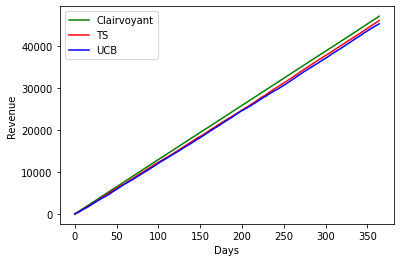

In [11]:
import matplotlib.pyplot as plt

#plt.figure(figsize=(10,3))
plt.plot(np.cumsum(clairvoyant_per_class_per_day), color='green', label='Clairvoyant')
plt.plot(np.cumsum(ts_rewards_per_class_per_day), color='red', label='TS')
plt.plot(np.cumsum(u_rewards_per_class_per_day), color='blue', label='UCB')

plt.legend()
plt.xlabel('Days')
plt.ylabel('Revenue')

Text(0, 0.5, 'Revenue')

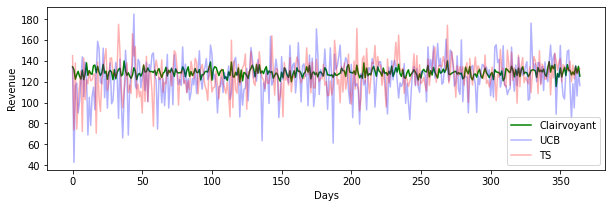

In [9]:
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter

plt.figure(figsize=(10,3))
plt.plot(clairvoyant_per_class_per_day, color='green',label='Clairvoyant')
plt.plot(u_rewards_per_class_per_day, color='blue', alpha=0.3, label='UCB')
plt.plot(ts_rewards_per_class_per_day, color='red', alpha=0.3, label='TS')

plt.legend()
plt.xlabel('Days')
plt.ylabel('Revenue')

Text(0, 0.5, 'Regret')

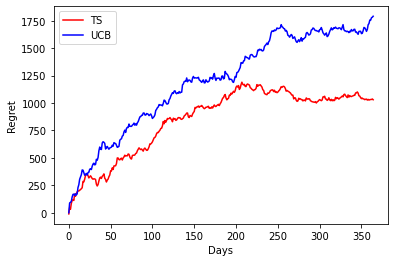

In [12]:
#plt.figure(figsize=(10,3))
plt.plot(np.cumsum(np.array(clairvoyant_per_class_per_day) - np.array(ts_rewards_per_class_per_day)), color='red', label='TS')
plt.plot(np.cumsum(np.array(clairvoyant_per_class_per_day) - np.array(u_rewards_per_class_per_day)), color='blue', label='UCB')

plt.legend()
plt.xlabel('Days')
plt.ylabel('Regret')